In [ ]:

%reload_ext autoreload
%autoreload 2
import os
import sys
sys.path.append('..')
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [32]:
dataset_path = '../data/processed_articles_dedup_nsfwtags_sarcasm.csv'
relevance_train_path = '../data/relevance_train.csv'
relevance_dev_path = '../data/relevance_dev.csv'
relevance_test_path = '../data/relevance_test.csv'
multiwords_path = '../data/multiword_expressions.txt'
stopwords_path = '../data/stopwords_updated.txt'

In [3]:
from src.utils import load_txt

mwes = load_txt(multiwords_path)
stopwords = load_txt(stopwords_path)

In [4]:
from src.document_preprocessor import RegexTokenizer

preprocessor = RegexTokenizer("\w+(?:-\w+)*(?:'[^stmrvld]\w*)*", lowercase=True, multiword_expressions=mwes)

# Query Expansion using WordNet

In [34]:
rel_train_df = pd.read_csv(relevance_train_path)
rel_queries = rel_train_df['query'].unique().tolist()

rel_dev_df = pd.read_csv(relevance_dev_path)
rel_queries += rel_dev_df['query'].unique().tolist()
len(rel_queries)

51

In [ ]:
from nltk.corpus import wordnet as wn
from nltk import pos_tag


def expand_query(tokens, stopwords, include_hypernyms=False):
    # POS tag the query tokens
    tokens_tagged = pos_tag(tokens)
    
    expanded_terms = []
    
    for word, pos in tokens_tagged:
        # Skip stopwords
        if word in stopwords:
            continue
        
        # Keep the original word
        expanded_terms.append(word)
        
        # Map POS tag to WordNet POS
        wn_pos = get_wordnet_pos(pos)
        
        if wn_pos:
            # Get synsets for the word
            synsets = wn.synsets(word, pos=wn_pos)
            
            if synsets:
                # Add original word
                expanded_terms.append(word)
                
                # Add lemma names from the first synset
                lemmas = synsets[0].lemma_names()
                expanded_terms.extend([lemma.replace('_', ' ').lower() 
                                       for lemma in lemmas if lemma != word])
                
                # Add hypernyms
                if include_hypernyms:
                    hypernyms = synsets[0].hypernyms()
                    if hypernyms:
                        expanded_terms.extend([h.replace('_', ' ').lower()
                                               for h in hypernyms[0].lemma_names()])
    
    # Remove duplicates
    return list(set(expanded_terms))


def get_wordnet_pos(treebank_tag: str) -> str:
    if treebank_tag.startswith('J'):
        return wn.ADJ
    elif treebank_tag.startswith('V'):
        return wn.VERB
    elif treebank_tag.startswith('N'):
        return wn.NOUN
    elif treebank_tag.startswith('R'):
        return wn.ADV
    else:
        return None

In [35]:
for query in rel_queries:
    print(f"Original query: '{query}'")
    print("Expanded using WordNet synonyms:", expand_query(preprocessor.tokenize(query), stopwords))
    print("Expanded using WordNet synonyms and hypernyms:", expand_query(preprocessor.tokenize(query), stopwords, include_hypernyms=True))
    print()

Original query: 'New York subway stories'
Expanded using WordNet synonyms: ['tube', 'narrative', 'underground', 'subway system', 'metro', 'story', 'stories', 'narration', 'tale', 'new york', 'subway']
Expanded using WordNet synonyms and hypernyms: ['subway system', 'substance', 'message', 'railway line', 'railroad', 'content', 'tale', 'narration', 'railway system', 'tube', 'underground', 'railroad line', 'railway', 'new york', 'subway', 'narrative', 'story', 'stories', 'subject matter', 'metro']

Original query: 'University of Michigan campus news'
Expanded using WordNet synonyms: ['news', 'tidings', 'word', 'intelligence', 'campus', 'university of michigan']
Expanded using WordNet synonyms and hypernyms: ['field', 'news', 'tidings', 'word', 'intelligence', 'campus', 'information', 'info', 'university of michigan']

Original query: 'how to get a job'
Expanded using WordNet synonyms: ['line', 'line of work', 'job', 'occupation', 'business']
Expanded using WordNet synonyms and hypernyms:

- Including hypernyms could potentially reduce precision, so we choose not to.
- Add query expansion feature to ranker and evaluate performance.

# Index

- No changes to the index as query expansion occurs @ query time

In [8]:
from src.indexing import Indexer, IndexType

index = Indexer.create_index(
    index_type=IndexType.BasicInvertedIndex, dataset_path=dataset_path, document_preprocessor=preprocessor, 
    stopwords=stopwords, minimum_word_frequency=0, text_key="body", id_key="docid"
)

35292it [00:11, 3104.46it/s]


In [9]:
index.save('output/index_mwe')

# Evaluate

In [10]:
rel_df = pd.read_csv(relevance_test_path)
len(rel_df)

654

## 1. TF-IDF

In [13]:
from src.ranker import TF_IDF, Ranker

tfidf_scorer = TF_IDF(index)
tfidf_ranker = Ranker(index, preprocessor, stopwords, tfidf_scorer, query_expansion=True)

In [21]:
from src.relevance import run_relevance_tests

metrics_tfidf_qe = run_relevance_tests(relevance_test_path, ranker=tfidf_ranker, encoding="utf-8-sig")
metrics_tfidf_qe['map'], metrics_tfidf_qe['ndcg']

(0.22495726495726498, 0.3782527259850465)

In [22]:
with open('output/metrics_tfidf_qe.json', 'w') as f:
    json.dump(metrics_tfidf_qe, f, indent=4)

## 2. BM25 

In [24]:
from src.ranker import BM25, Ranker

bm25_scorer = BM25(index)
bm25_ranker = Ranker(index, preprocessor, stopwords, bm25_scorer, query_expansion=True)

In [25]:
from src.relevance import run_relevance_tests

metrics_bm25_qe = run_relevance_tests(relevance_test_path, ranker=bm25_ranker, encoding="utf-8-sig")
metrics_bm25_qe['map'], metrics_bm25_qe['ndcg']

(0.24937721669864527, 0.39584057912356313)

In [26]:
with open('output/metrics_bm25_qe.json', 'w') as f:
    json.dump(metrics_bm25_qe, f)

## Compare

In [27]:
# Generated in 02_Baselines.ipynb
with open('output/metrics_random.json', 'r') as f:
    metrics_random = json.load(f)
    
with open('output/metrics_tfidf.json', 'r') as f:
    metrics_tfidf = json.load(f)
    
with open('output/metrics_bm25.json', 'r') as f:
    metrics_bm25 = json.load(f)

In [28]:
# Generated in `08_Multi_Word_Expressions.ipynb`
with open('output/metrics_tfidf_mwe.json', 'r') as f:
    metrics_tfidf_mwe = json.load(f)
    
with open('output/metrics_bm25_mwe.json', 'r') as f:
    metrics_bm25_mwe = json.load(f)

In [29]:
metrics = {
    "Random": metrics_random,
    "TF-IDF": metrics_tfidf,
    "BM25": metrics_bm25,
    "TF-IDF (MWE)": metrics_tfidf_mwe,
    "BM25 (MWE)": metrics_bm25_mwe,
    'TF-IDF (MWE + QE)': metrics_tfidf_qe,
    'BM25 (MWE + QE)': metrics_bm25_qe    
}

metrics_df = []
for ranker, metrics in metrics.items():
    metrics_df.append({
        "ranker": ranker, "metric": "MAP@10", 
        "mean_score": metrics["map"], "scores": metrics["map_list"]
    })
    metrics_df.append({
        "ranker": ranker, "metric": "NDCG@10", 
        "mean_score": metrics["ndcg"], "scores": metrics["ndcg_list"]
    })
    

metrics_df = pd.DataFrame(metrics_df)
metrics_df_long = metrics_df.drop("mean_score", axis=1).explode("scores")

In [30]:
metrics_df_long.to_csv("output/metrics_baselines_mwe_qe.csv", index=False)

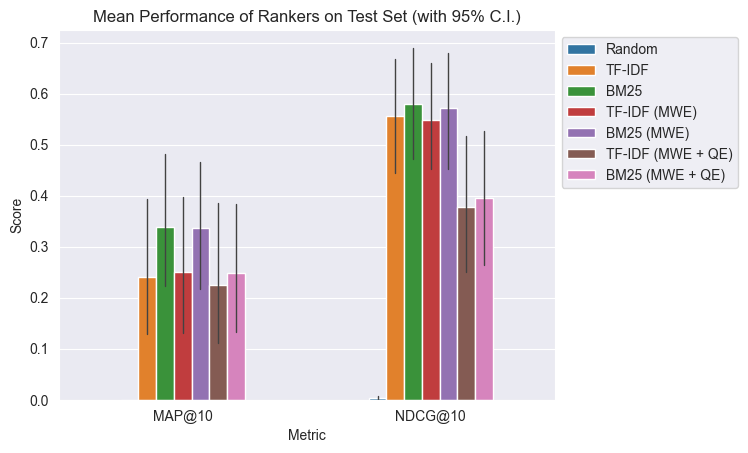

In [31]:
sns.barplot(data=metrics_df_long, x="metric", y="scores", hue="ranker", 
            estimator='mean', errorbar=('ci', 95), width=0.5, errwidth=1)

plt.title("Mean Performance of Rankers on Test Set (with 95% C.I.)")
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("Metric")
plt.ylabel("Score")
plt.show()

## Check query expansion on test queries

In [36]:
bm25_ranker = Ranker(index, preprocessor, stopwords, bm25_scorer)

In [41]:
test_df = pd.read_csv(relevance_test_path)

for query, qdf in test_df.groupby('query'):
    print(f"Original query: '{query}'")
    print("Expanded using WordNet synonyms:", expand_query(preprocessor.tokenize(query), stopwords))
    print()
    
#     doc_rels = qdf.set_index('docid')['rel'].sort_values(ascending=False).to_dict()
#     print(f"Query: '{query}'")
#     print("Ground truth relevance:", doc_rels)
#     print("BM25 (MWE):", bm25_ranker.query(query))
#     print("BM25 (MWE + QE):", bm25_ranker.query(query, expand=True))
#     print()
    

Original query: 'Hollywood celebrity scandals'
Expanded using WordNet synonyms: ['famous person', 'scandal', 'dirt', 'celebrity', 'scandals', 'hollywood', 'malicious gossip']

Original query: 'cool science facts'
Expanded using WordNet synonyms: ['fact', 'science', 'facts', 'cool', 'scientific discipline']

Original query: 'how to deal with an emotional friend'
Expanded using WordNet synonyms: ['plow', 'address', 'handle', 'cover', 'deal', 'emotional', 'friend', 'treat']

Original query: 'how to make money'
Expanded using WordNet synonyms: ['money', 'make', 'do']

Original query: 'how to scam people'
Expanded using WordNet synonyms: ['diddle', 'hornswoggle', 'rook', 'gyp', 'bunco', 'defraud', 'people', 'gip', 'con', 'victimize', 'mulct', 'swindle', 'scam', 'short-change', 'nobble', 'goldbrick']

Original query: 'popular social media trends'
Expanded using WordNet synonyms: ['trend', 'trends', 'popular', 'tendency', 'social media']

Original query: 'urban myths and legends'
Expanded usi